In [1]:
! pip install -q optax equinox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 6.1 MB/s eta 0:00:00


In [2]:
import jax.numpy as jnp
import equinox as eqx
import optax
import time
import requests

from jax import config, random, vmap
from jax.tree_util import tree_map, tree_flatten
from jax.lax import dot_general, scan, dynamic_slice_in_dim
from jax.nn import gelu
from urllib.parse import urlencode

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

# Factorized Fourier Neural Operator

Factorized Fourier Neural Operator (FFNO) introduced in https://arxiv.org/abs/2111.13802 is a variant of Fourier Neural Operator (FNO) introduced in https://arxiv.org/abs/2010.08895 (also in https://arxiv.org/abs/1506.03767) that is more computationaly friendly and easier to implement.

For $D=1$ case FNO take $n=1,\dots,N$ functions evaluated on the uniform grid $x_i,\,i=1,\dots,M$ as an input $u^{(n)}_{i} = u^{(n)}(x_{i})$ and output $p=1,\dots,K$ functions evaluated on the same grid. To do that FNO combine spectral convolution with ordinary convolution with kernel size equals $1$, i.e.,
\begin{equation}
    \widetilde{u} = \text{spectral conv}[u] + \text{conv}[u].
\end{equation}

Convolution is defined by a weight matrix $W_{s}$ ans a bias $b_{s}$:
\begin{equation}
    \text{conv}[u]_{i}^{(p)} = \sum_{n=1}^{N}W_{s}^{(pn)}u_{i}^{(n)} + b_{s}^{(p)}.
\end{equation}
Spectral convolution is performed in a Fourier space:
\begin{equation}
    \text{spectral conv}[u]_{i}^{(p)} = \left(\text{iFFT}\left[\sum_{n=1}^{N}D_{k}^{(pn)}\left(\text{FFT}[u^{(n)}]_{1:N_{\text{modes}}}\right)_{k}\right]\right)_{i}.
\end{equation}

The main problem is the number of parameters which will grow as $N_{\text{modes}}^{D} \times N_{\text{features}}^{2}$ with dimension $D$. FFNO solves this problem by performing separate spectral convolutions along each dimension and in addition introducting skip connection to improve training when depth increases.

More specifically, FFNO has the structure
\begin{equation}
\text{encoder} \rightarrow \text{FFNO block + skip} \rightarrow \dots \rightarrow \text{FFNO block + skip} \rightarrow \text{decoder},
\end{equation}
where encoder and decoder are convolutions with kernel size $1$ and FFNO block is
\begin{equation}
\text{spectral conv } d=1 \rightarrow \dots \rightarrow \text{spectral conv } d=D \rightarrow \text{conv kernel size } 1 \rightarrow \text{gelu} \rightarrow \text{conv kernel size } 1 \rightarrow \text{gelu}.
\end{equation}

This architecture is implemented below for arbitrary $D$.

Note that the number of parameters of spectral convolution block is $D\times N_{\text{modes}} \times N^{2}_{\text{features}}.$

In [3]:
def normalize_conv(A):
    A = eqx.tree_at(lambda x: x.weight, A, A.weight*jnp.sqrt(2/A.weight.shape[1]))
    A = eqx.tree_at(lambda x: x.bias, A, jnp.zeros_like(A.bias))
    return A

class FFNO(eqx.Module):
    encoder: eqx.Module
    decoder: eqx.Module
    convs1: list
    convs2: list
    A: jnp.array

    def __init__(self, N_layers, N_features, N_modes, key, D=1):
        n_in, n_processor, n_out = N_features

        keys = random.split(key, 3 + 2*N_layers)
        self.encoder = normalize_conv(eqx.nn.Conv(D, n_in, n_processor, 1, key=keys[-1]))
        self.decoder = normalize_conv(eqx.nn.Conv(D, n_processor, n_out, 1, key=keys[-2]))
        self.convs1 = [normalize_conv(eqx.nn.Conv(D, n_processor, n_processor, 1, key=key)) for key in keys[:N_layers]]
        self.convs2 = [normalize_conv(eqx.nn.Conv(D, n_processor, n_processor, 1, key=key)) for key in keys[N_layers:2*N_layers]]
        self.A = random.normal(keys[-3], [N_layers, n_processor, n_processor, N_modes, D], dtype=jnp.complex64)*jnp.sqrt(2/n_processor)

    def __call__(self, u, x):
        u = jnp.concatenate([x, u], 0)
        u = self.encoder(u)
        for conv1, conv2, A in zip(self.convs1, self.convs2, self.A):
            u += gelu(conv2(gelu(conv1(self.spectral_conv(u, A)))))
        u = self.decoder(u)
        return u

    def spectral_conv(self, v, A):
        u = 0
        N = v.shape
        for i in range(A.shape[-1]):
            u_ = dynamic_slice_in_dim(jnp.fft.rfft(v, axis=i+1), 0, A.shape[-2], axis=i+1)
            u_ = dot_general(A[:, :, :, i], u_, (((1,), (0,)), ((2, ), (i+1, ))))
            u_ = jnp.moveaxis(u_, 0, i+1)
            u += jnp.fft.irfft(u_, axis=i+1, n=N[i+1])
        return u

def compute_loss(model, features, coordinates, targets):
    prediction = vmap(model, in_axes=(0, None))(features, coordinates)
    mean_error = jnp.mean(jnp.linalg.norm((prediction - targets).reshape(prediction.shape[0], -1), axis=1))
    return mean_error

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

def make_step(carry, n, optim):
    model, features, coordinates, targets, opt_state = carry
    loss, grads = compute_loss_and_grads(model, features[n], coordinates, targets[n])
    grads = tree_map(lambda x: x.conj(), grads)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return [model, features, coordinates, targets, opt_state], loss

def compute_relative_error(model, features, targets, n):
    prediction = vmap(model, in_axes=(0, None))(features[n], coordinates)
    relative_error = jnp.linalg.norm((prediction - targets[n]).reshape(n.size, -1), axis=1) / jnp.linalg.norm(targets[n].reshape(n.size, -1), axis=1)
    return relative_error

# KdV D=1

In [4]:
def s(x, t, c):
    return c/jnp.cosh(jnp.sqrt(c)*((x-c*t)%1.0-0.5)/2)**2/2

def get_dataset_KdV_1D(key=random.PRNGKey(11), N_samples=1000, c_min = 500, c_max = 900, delta_t = 0.3*1/700, N_x=100, normalize=False):
    x = jnp.linspace(0, 1, N_x)
    keys = random.split(key)
    c = c_min + (c_max - c_min) * random.uniform(keys[0], (N_samples,))
    x0 = random.uniform(keys[1], (N_samples,))
    t0 = x0 / c
    t1 = t0 + delta_t
    features = vmap(s, in_axes=(None, 0, 0))(x, t0, c)
    targets = vmap(s, in_axes=(None, 0, 0))(x, t1, c)
    features = jnp.expand_dims(features, 1)
    targets = jnp.expand_dims(targets, 1)

    if normalize:
        features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
        targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2], keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale

    return features, targets, jnp.expand_dims(x, 0)

dataset generation time: 1.43095 s
Shapes of features, targets and coordinates: (1000, 1, 100) (1000, 1, 100) (1, 100)
model size: 8209
training time: 8.71452 s
train error 0.018677882850170135, test error 0.019008422270417213


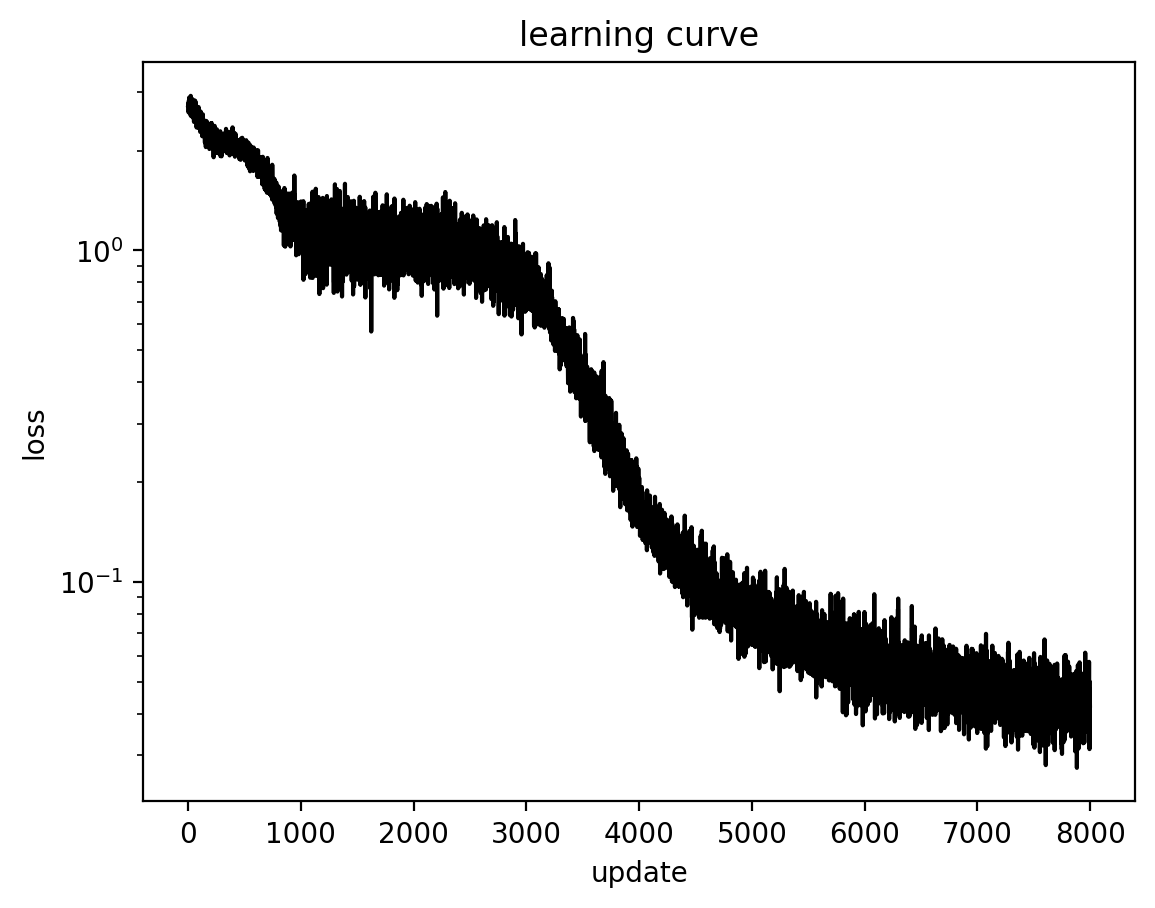

In [5]:
# generate dataset
N_samples = 1000
key = random.PRNGKey(11)
start = time.time()
features, targets, coordinates = get_dataset_KdV_1D(key=key, N_samples=N_samples, normalize=True)
stop = time.time()
print("dataset generation time:", round(stop - start, ndigits=5), "s")

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
N_modes = 12
N_layers = 4
N_features = [coordinates.shape[0] + features.shape[1], 12, 1]
key = random.PRNGKey(11)
model = FFNO(N_layers, N_features, N_modes, key)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 1e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 10
N_run = 8000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");

# Elliptic D=1

In [6]:
def get_coordinates(N):
    x = jnp.linspace(0, 1, N+2)[1:]
    h = x[1] - x[0]
    x_half = x - h/2
    return x_half, x[:-1]

def get_matrix(sigma_half):
    A = jnp.diag(sigma_half[:-1] + sigma_half[1:]) - jnp.diag(sigma_half[1:-1], k=-1) - jnp.diag(sigma_half[1:-1], k=1)
    return A

def get_matrices(x, N, p, l):
    return jnp.stack([jnp.exp(1j*x*2*jnp.pi*k) / (1 + (2*jnp.pi*k / l)**2)**p for k in range(N)], 1)

def get_diffusion_coefficient(key, M, s):
    coeff = random.normal(key, (M.shape[1],), dtype=jnp.complex64)
    sigma = jnp.real(M @ coeff)
    sigma = s*(sigma - jnp.min(sigma)) / (jnp.max(sigma) - jnp.min(sigma)) + 1
    return sigma

def piecewise_linear_diffusion_coefficient(key, x, s, k):
    keys = random.split(key)
    vals = random.uniform(keys[0], (k,), minval=1, maxval=s)
    coords = random.uniform(keys[1], (k,))
    coords = coords.at[0].set(0)
    coords = coords.at[-1].set(1)
    return jnp.interp(x, coords, vals)

def get_data(key, N_samples, constant_rhs=False, laplace=False, N = 100, s=4):
    M = 150
    p = 2
    l = 10
    k = 5
    x_half, x = get_coordinates(N)
    h = x[1] - x[0]
    T = get_matrices(x_half, M, p, l)
    T_x = get_matrices(x, M, p, l)
    keys = random.split(key, N_samples)

    features = []
    targets = []
    Matrices = []
    for key in keys:
        key1, key2 = random.split(key)
        if laplace:
            sigma = jnp.ones_like(x_half)
        else:
            sigma = get_diffusion_coefficient(key1, T, s)
        A = get_matrix(sigma)

        if constant_rhs:
            b = jnp.ones((N,))
        else:
            coeff = random.normal(key2, (T_x.shape[1],), dtype=jnp.complex64)
            b = jnp.real(T_x @ coeff)
        b = h**2 * b
        sol = jnp.linalg.solve(A, b)
        sigma = get_diffusion_coefficient(key1, T_x, s)
        if laplace:
            sigma = jnp.ones_like(x)
        features.append(jnp.stack([sigma, b/h**2]))
        targets.append(sol)
    features = jnp.stack(features, 0)
    targets = jnp.expand_dims(jnp.stack(targets, 0), 1)
    return features, targets, jnp.expand_dims(x, 0)

def get_dataset_elliptic_1D(name, N_samples=1000, key=random.PRNGKey(33), N=100, s=4, normalize=False):
    if name == "Dataset 1":
        features, targets, coordinates = get_data(key, N_samples, constant_rhs=False, laplace=False, N=N, s=s)
    elif name == "Dataset 2":
        features, targets, coordinates = get_data(key, N_samples, constant_rhs=True, laplace=False, N=N, s=s)
    else:
        features, targets, coordinates = get_data(key, N_samples, constant_rhs=False, laplace=True, N=N, s=s)

    if normalize:
        features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
        targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2], keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale
    return features, targets, coordinates

dataset generation time: 10.75931 s
Shapes of features, targets and coordinates: (1000, 2, 100) (1000, 1, 100) (1, 100)
model size: 8221
training time: 15.11222 s
train error 0.05989197641611099, test error 0.06550021469593048


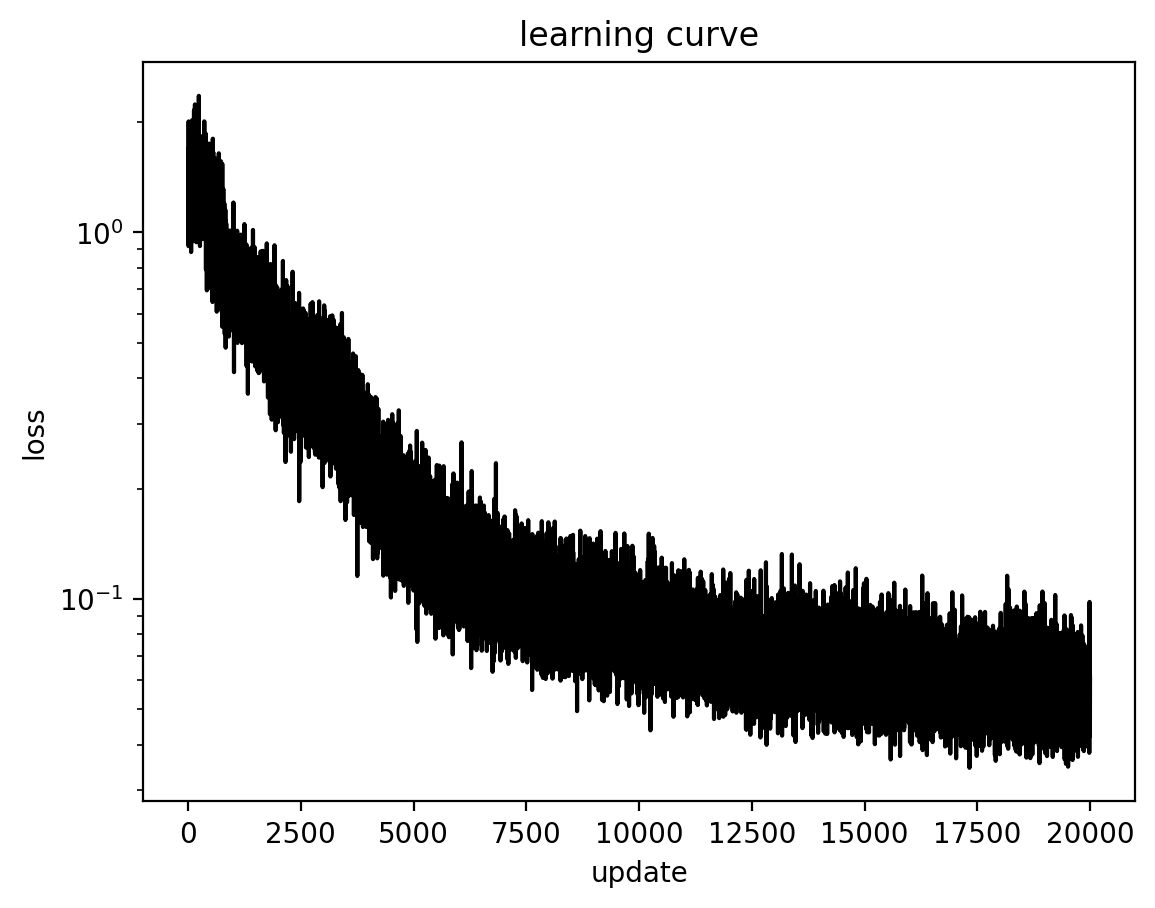

In [7]:
# generate dataset
N_samples = 1000
key = random.PRNGKey(11)
start = time.time()
features, targets, coordinates = get_dataset_elliptic_1D('Dataset 1', N_samples=N_samples, normalize=True)
stop = time.time()
print("dataset generation time:", round(stop - start, ndigits=5), "s")
print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
N_modes = 12
N_layers = 4
N_features = [coordinates.shape[0] + features.shape[1], 12, 1]
key = random.PRNGKey(11)
model = FFNO(N_layers, N_features, N_modes, key)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 1e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 20
N_run = 20000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");

# KdV D=2

In [8]:
def s(x, t, c):
    return c/jnp.cosh(jnp.sqrt(c)*((x-c*t)%1.0-0.5)/2)**2/2

def get_dataset_KdV_2D(key=random.PRNGKey(11), N_samples=1000, c_min=500, c_max=900, delta_t=0.3*1/700, N_x=100, N_t=100, normalize=False):
    x = jnp.linspace(0, 1, N_x)
    keys = random.split(key)
    c = c_min + (c_max - c_min) * random.uniform(keys[0], (N_samples,))
    x0 = random.uniform(keys[1], (N_samples,))
    t0 = x0 / c
    t = delta_t * jnp.linspace(0, 1, N_t)
    X, T = jnp.meshgrid(x, t)
    coordinates = jnp.stack([X, T], 0)
    t = jnp.expand_dims(t, 0) + jnp.expand_dims(t0, 1)
    t = jnp.expand_dims(t, 2)
    x = jnp.expand_dims(x, 0)
    solutions = vmap(s, in_axes=(None, 0, 0))(x, t, c) # solutions.shape = (N_samples, N_t, N_x)

    features = solutions[:, :1, :]
    targets = jnp.expand_dims(solutions, 1)

    if normalize:
        features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
        targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2, 3], keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale

    return features, targets, coordinates

dataset generation time: 1.08835 s
Shapes of features, targets and coordinates: (1000, 1, 100, 100) (1000, 1, 100, 100) (2, 100, 100)
model size: 15133
training time: 196.8384 s
train error 0.041399192065000534, test error 0.04184176027774811


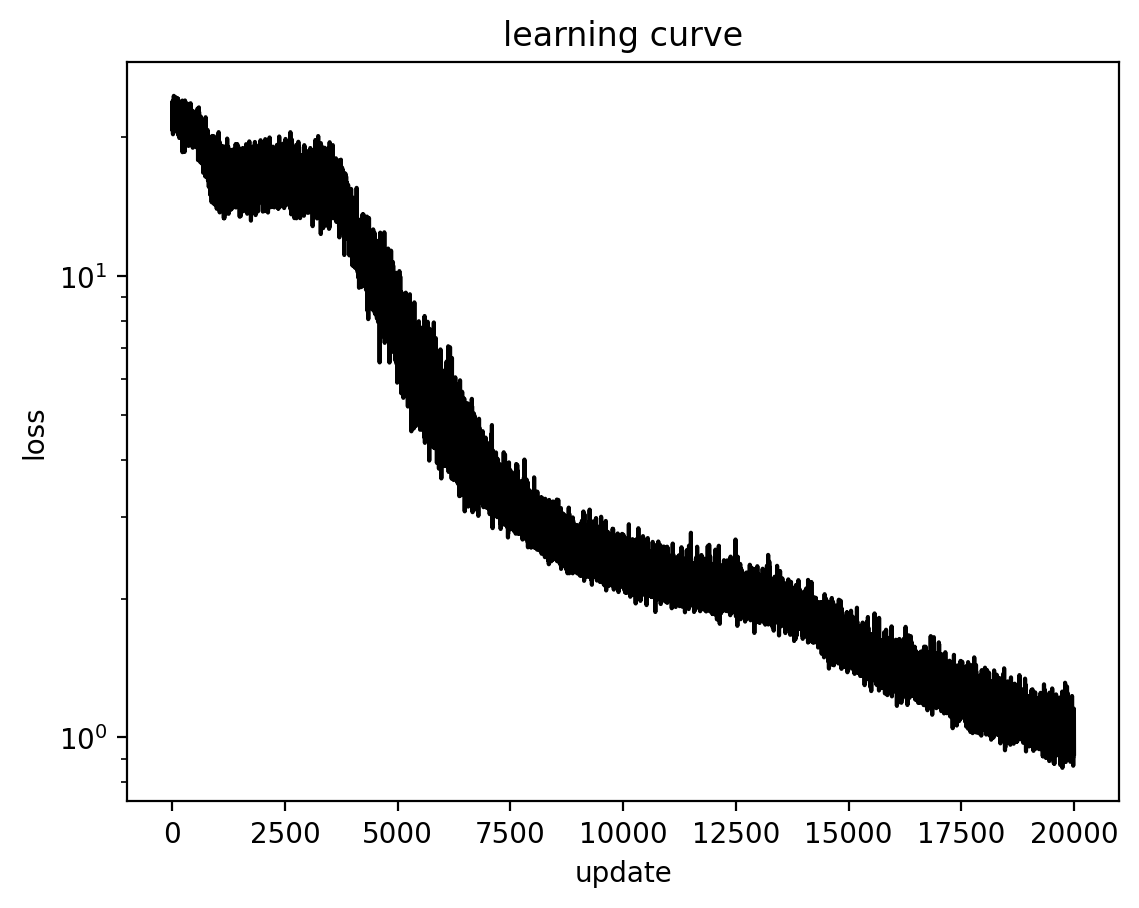

In [9]:
# generate dataset
N_samples = 1000
key = random.PRNGKey(11)
start = time.time()
features, targets, coordinates = get_dataset_KdV_2D(key=key, N_samples=N_samples, normalize=True)
stop = time.time()
print("dataset generation time:", round(stop - start, ndigits=5), "s")

# u_0(x) -> u_0(x, t) = u_0(x)
features = jnp.expand_dims(features, 2) + jnp.zeros_like(targets)

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
N_modes = 12
N_layers = 4
N_features = [coordinates.shape[0] + features.shape[1], 12, 1]
key = random.PRNGKey(11)
model = FFNO(N_layers, N_features, N_modes, key, D=2)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 1e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 10
N_run = 20000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");

# Elliptic D=2

Shapes of features, targets and coordinates: (1000, 2, 64, 64) (1000, 1, 64, 64) (2, 64, 64)
model size: 15145
training time: 116.56382 s
train error 0.0765208825469017, test error 0.07739152759313583


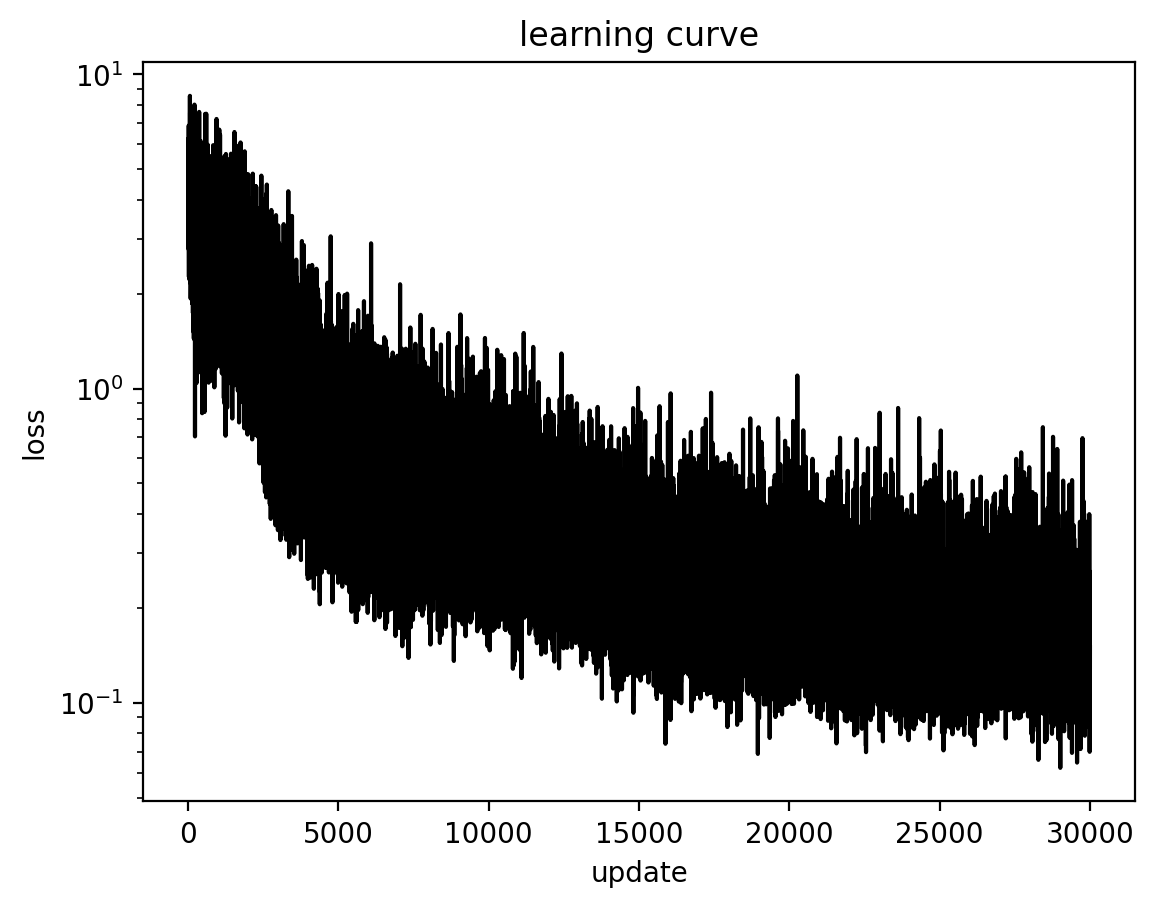

In [10]:
# # download dataset
# # in case this code fails, download using the link and upload to colab / mount your google drive
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/fz9ghnFEDm90Qw' # public link

# final_url = base_url + urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']

# download_response = requests.get(download_url)
# with open('Elliptic.npz', 'wb') as f:
#     f.write(download_response.content)

data = jnp.load('Elliptic.npz')
features, targets, coordinates = data["features"], data["targets"], data["coordinates"]

features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2, 3], keepdims=True)
features = features / features_scale
targets = targets / targets_scale

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
N_modes = 12
N_layers = 4
N_features = [coordinates.shape[0] + features.shape[1], 12, 1]
key = random.PRNGKey(11)
model = FFNO(N_layers, N_features, N_modes, key, D=2)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 1e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 10
N_run = 30000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");

# Burgers D=1+1

Shapes of features, targets and coordinates: (1000, 1, 100, 100) (1000, 1, 100, 100) (2, 100, 100)
model size: 15133
training time: 100.41957 s
train error 0.046131234616041183, test error 0.04717965051531792


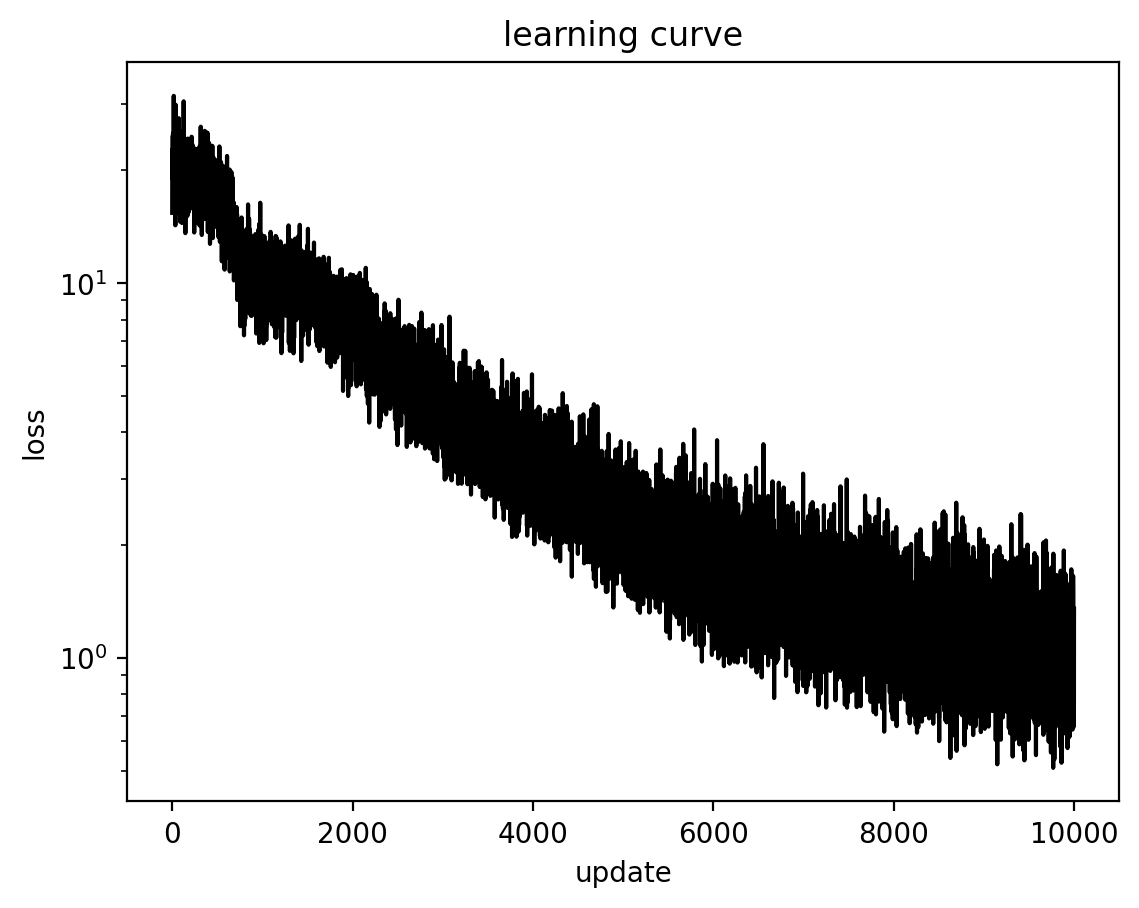

In [12]:
# # download dataset
# # in case this code fails, download using the link and upload to colab / mount your google drive
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/kkcRqJYIIkRUgw' # public link

# final_url = base_url + urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']

# download_response = requests.get(download_url)
# with open('Burgers.npz', 'wb') as f:
#     f.write(download_response.content)

data = jnp.load('Burgers.npz')
features, targets, coordinates = data["features"], data["targets"], data["coordinates"]

features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2, 3], keepdims=True)
features = features / features_scale
targets = targets / targets_scale

# u(x, t=0) -> u(x, t) = u(x, t=0), i.e., D=1 -> D=1+1
features = jnp.expand_dims(features, 2) + jnp.zeros_like(targets)

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
N_modes = 12
N_layers = 4
N_features = [coordinates.shape[0] + features.shape[1], 12, 1]
key = random.PRNGKey(11)
model = FFNO(N_layers, N_features, N_modes, key, D=2)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 1e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 10
N_run = 10000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");